In [1]:
import torch
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import functools

from SDE import marginal_prob_std_fn_2D as marginal_prob_std_fn
from SDE import diffusion_coeff_fn_2D as diffusion_coeff_fn

In [4]:
actual_samples_pos_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 10000) + 1.2)
actual_samples_0_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 10000) + 0)
actual_samples_neg_2 = np.tanh(np.random.normal(0,np.sqrt(0.05), size = 10000) - 1.2)
data = np.concatenate((actual_samples_pos_2, actual_samples_0_2,actual_samples_neg_2))

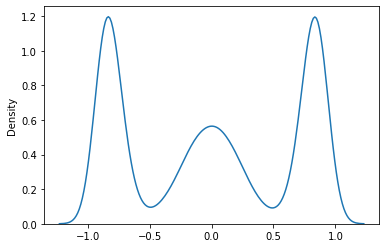

In [5]:
sns.kdeplot(data)

In [6]:
def marginal_prob_dist(t, beta_min, beta_max):
    t_squared = torch.pow(t, 2)
    mean_coeff = torch.exp(-1/4 * t_squared * (beta_max - beta_min) - 1/2 * t * beta_min)
    sd = 1 - torch.exp(-1/2 * t_squared * (beta_max - beta_min) - t * beta_min)
    return mean_coeff, sd

def beta_t(t, beta_min, beta_max):
    return beta_min + t*(beta_max - beta_min)

beta_min = 0.1
beta_max = 20

marginal_prob_dist_fn = functools.partial(marginal_prob_dist, beta_min=beta_min, beta_max=beta_max)
beta_t_fn = functools.partial(beta_t, beta_min=beta_min, beta_max=beta_max)

In [94]:
def diffuse(data, n, beta_t):
    t = 0
    dt = 1/n
    diffused = [data]
    
    for i in range(n):
        b = beta_t(t)
        dx = -1/2 * b * data*dt + np.sqrt(b*dt) * np.random.randn(1)[0]
        data += dx
        t += dt
        diffused.append(data)
        
    return diffused

In [111]:
sample = np.random.choice(data, 5)

walks = []
for i in sample:
    walk = diffuse(i, 1000, beta_t_fn)
    walks.append(walk)

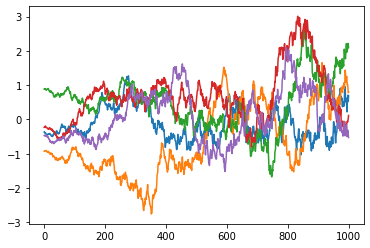

In [112]:
for i in range(len(sample)):
    plt.plot(walks[i])

In [113]:
last = [diffuse(data[i], 1000, beta_t_fn)[-1] for i in range(1000)]

In [114]:
np.mean(last)

-0.029156278015969286

In [115]:
np.var(last)

1.031426989503358

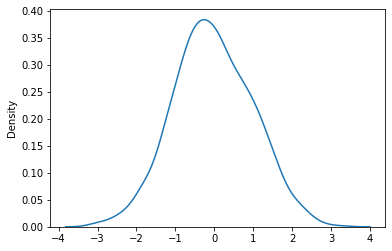

In [116]:
sns.kdeplot(last)

In [117]:
def get_diffused(data, n, diffusion_coeff):
    t = 0
    dt = 1/n
    diffused = [data]
    for i in range(n):
        g = diffusion_coeff(t).item()
        data += g * np.random.randn(1)[0] * np.sqrt(dt)
        t += dt
        diffused.append(data)
        
    return diffused

In [119]:
sample = np.random.choice(data, 5)

walks = []
for i in sample:
    walk = get_diffused(i, 1000, diffusion_coeff_fn)
    walks.append(walk)

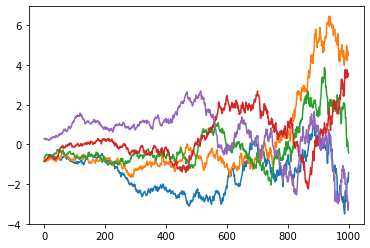

In [120]:
for i in range(len(sample)):
    plt.plot(walks[i])

In [125]:
torch.tensor(walk, dtype = torch.float32)[:,None]

tensor([[ 0.2976],
        [ 0.2659],
        [ 0.2805],
        ...,
        [-3.3194],
        [-3.3232],
        [-2.9357]])

In [107]:
last = [get_diffused(data[i], 1000, diffusion_coeff_fn)[-1] for i in range(1000)]

In [108]:
np.mean(last)

0.9433973173145084

In [109]:
np.var(last)

14.018681309656724

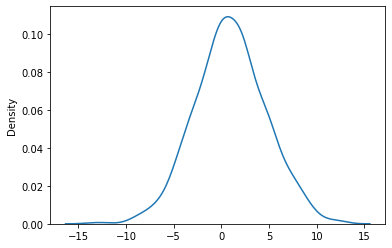

In [110]:
sns.kdeplot(last)

In [199]:
def get_diffused_2D(data, n, diffusion_coeff):
    t = 0
    dt = 1/n
    diffused = [data.clone().detach()]
    for i in range(n):
        g = diffusion_coeff(t).reshape(1)

        data += g * torch.randn(5) * np.sqrt(dt)

        t += dt
        diffused.append(data.clone().detach())
        
    return torch.vstack(diffused)
    #return torch.tensor(diffused, dtype = torch.float32)[:,None]

In [200]:
y_obs = torch.tensor([0.5,0.5,0.5,0.5,0.5])

In [208]:
get_diffused_2D(y_obs.clone().detach(),10,diffusion_coeff_fn)

tensor([[ 0.5000,  0.5000,  0.5000,  0.5000,  0.5000],
        [ 0.6651,  0.2828,  0.4486,  0.4268,  0.1033],
        [ 0.3694,  0.1179,  0.1461,  0.0945,  0.5721],
        [ 0.0671,  0.3279,  0.7354, -0.6350,  0.5119],
        [ 0.3347,  0.4932,  0.9843, -0.9293,  0.1689],
        [ 0.8326,  1.8069, -0.0762, -0.7701, -0.2459],
        [ 0.8452,  1.0691, -1.3171, -1.7015, -0.6531],
        [ 1.2185,  0.6467, -0.7445, -1.3472, -1.4718],
        [ 1.4135,  3.1026, -1.1424, -3.0351, -2.1140],
        [-1.2830,  5.2173, -0.4458, -4.6152, -4.0737],
        [-3.4776, -1.8324, -1.8414, -3.9662, -2.6618]])

In [202]:
def get_diffused_y(y_obs, timesteps, marginal_prob_std):
    timesteps = torch.flip(timesteps, [0])
    sd = marginal_prob_std(timesteps).reshape(timesteps.shape[0], 1)
    diffused_y = y_obs + torch.randn(timesteps.shape[0], y_obs.shape[0]) * sd
    return diffused_y

In [209]:
get_diffused_y(y_obs.clone().detach(), torch.linspace(1,0,10), marginal_prob_std_fn)

tensor([[ 0.5000,  0.5000,  0.5000,  0.5000,  0.5000],
        [-0.1004,  0.4027,  0.1837,  0.1808,  0.4922],
        [ 0.1671,  0.3929,  1.2274, -0.0752, -1.1798],
        [ 0.7403,  0.6796,  1.0994,  1.2929, -0.7134],
        [ 2.4865,  0.8285, -0.3755,  1.8753, -2.1838],
        [ 2.1786,  0.7093,  0.9394,  0.9206,  2.0108],
        [ 1.7701, -0.7846,  2.9140, -2.8611,  2.0992],
        [-2.0863,  0.4121,  0.3100, -0.8351, -1.3217],
        [ 2.5005,  6.4000, -5.7040,  2.5849, -5.3441],
        [-2.8312, -4.5623,  7.1125,  2.0496,  4.3131]])